**Exploratory Analysis**

dict_values([45, 801, 67, 33, 58, 39, 38, 47, 94, 60, 34])
dict_keys(['IND', 'NSR', 'CON', 'INT', 'MAI', 'AVA', 'AUD', 'IMM', 'THE', 'THO', 'SUR'])


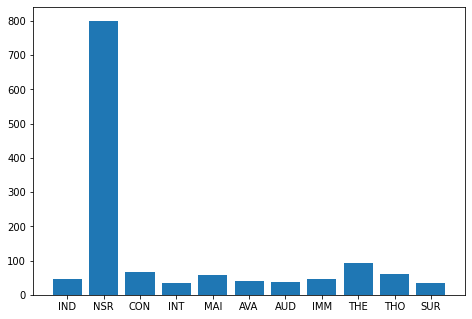

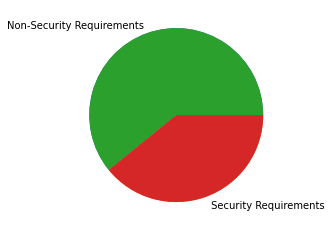

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# read datasets and count
sre_df = pd.read_csv('/content/Input/dosspre.csv', sep=',', encoding='cp1252', header=0, quotechar = '"')

store=sre_df['class']
c=Counter(store)
print(c.values())
print(c.keys())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['IND', 'NSR', 'CON', 'INT', 'MAI', 'AVA', 'AUD', 'IMM', 'THE', 'THO', 'SUR']
students = [45, 801, 67, 33, 58, 39, 38, 47, 94, 60, 34]
ax.bar(langs,students)
plt.show()


y = np.array([801,515])
mylabels = ["Non-Security Requirements", " Security Requirements" ]

plt.pie(y, labels = mylabels)
plt.pie(y)
plt.show() 

**Dataset Normalization**

In [ ]:
import pandas as pd
from collections import defaultdict
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
#from nltk.corpus import averaged_perceptron_tagger

df = pd.read_csv('/content/Input/dosspre.csv', sep=',', encoding='cp1252', header=0, quotechar = '"', doublequote=True)

# remove the project information as the project does not ulitize it at all
del df['ProjectID']

def process_requirement_text(text):
    # convert to lowercase and tokenize (a token is either a word or interpunction symbols)
    tokens = word_tokenize(text.lower())

    # filter out non-alphabetic strings, and stopwords ('a', 'the', etc.)
    # what remains will either be nouns, verbs, adjectives or adverbs
    # finally, perform lemmatization, i.e. replacing each word with its "root" form (e.g.: plural to singular form for nouns, past to present tense for verbs, etc.)
    resulting_words = []
    lemmatizer = WordNetLemmatizer()

    english_stopwords = stopwords.words('english')
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    for word, tag in pos_tag(tokens):
        if word.isalpha() and word not in english_stopwords:
            resulting_words.append(
                lemmatizer.lemmatize(word, tag_map[tag[0]]))

    return ' '.join(resulting_words)

df['RequirementText'] = df['RequirementText'].apply(process_requirement_text)

df.to_csv('/content/Output/dataset_normalized.csv', sep=',', header=True, index=False, quotechar = '"', doublequote=True)


**BOW and TF_IDF - Vectorization**

In [4]:
from math import log
import numpy as np
import pandas as pd

df = pd.read_csv('/content/Output/dataset_normalized.csv', sep=',', header=0, quotechar = '"', doublequote=True)

# manual vectorization; not using CountVectorizer and TfidfVectorizer from sklearn.feature_extraction

features_set = set()
vector_list = [None] * df.shape[0]

for index, row in df.iterrows():
    text = row['RequirementText']
    tokens = text.split(' ')
    row_vector = {}
    for token in tokens:
        features_set.add(token)
        if token in row_vector:
            row_vector[token] = row_vector[token] + 1
        else:
            row_vector[token] = 1
    vector_list[index] = row_vector

features_sorted = list(features_set)
features_sorted.sort()
features_sorted_lookup_map = { value: index for index, value in enumerate(features_sorted) }

vector_matrix_bow = np.zeros((df.shape[0], len(features_set)), dtype=np.int16)

for i in range(len(vector_list)):
    row_dict = vector_list[i]
    for k, v in row_dict.items():
        vector_matrix_bow[i, features_sorted_lookup_map[k]] = v

bow_df = pd.DataFrame(data=vector_matrix_bow, columns=features_sorted)
bow_df['class'] = df['class']
bow_df.to_csv('/content/Output/dataset_bow.csv', sep=',', header=True, index=False)

vector_matrix_tfidf = np.zeros((df.shape[0], len(features_set)))
row_sums_bow = vector_matrix_bow.sum(axis=1)
col_sums_bow = vector_matrix_bow.sum(axis=0)

for i in range(vector_matrix_bow.shape[0]):
    for j in range(vector_matrix_bow.shape[1]):
        if vector_matrix_bow[i, j] == 0:    # minor optimization
            continue
        tf = vector_matrix_bow[i, j] / row_sums_bow[i]
        idf = log(vector_matrix_bow.shape[0] / col_sums_bow[j])
        vector_matrix_tfidf[i, j] = tf * idf

tfidf_df = pd.DataFrame(data=vector_matrix_tfidf, columns=features_sorted)
tfidf_df['class'] = df['class']
tfidf_df.to_csv('/content/Output/dataset_tfidf.csv', sep=',', header=True, index=False)

# bow_df and tfidf_df are (very) sparse matrices of shape (969, 1524)


**2-class, 11-class and 10-class-- Feature Selection**

In [5]:
import pandas as pd
bow_df = pd.read_csv('/content/Output/dataset_bow.csv', sep=',', header=0)
tfidf_df = pd.read_csv('/content/Output/dataset_tfidf.csv', sep=',', header=0)

# 11-class datasets (no changes, rename for consistency)
bow_twelve_df = bow_df
bow_twelve_df.to_csv('/content/feature/1-bow-11.csv', sep=',', header=True, index=False)

tfidf_twelve_df = tfidf_df
tfidf_twelve_df.to_csv('/content/feature/1-tfidf-11.csv', sep=',', header=True, index=False)

# 10-class datasets
bow_eleven_df = bow_df.copy()
bow_eleven_df = bow_eleven_df[bow_eleven_df['class'] != 'NSR']
bow_eleven_df.to_csv('/content/feature/1-bow-10.csv', sep=',', header=True, index=False)

tfidf_eleven_df = tfidf_df.copy()
tfidf_eleven_df = tfidf_eleven_df[tfidf_eleven_df['class'] != 'NSR']
tfidf_eleven_df.to_csv('/content/feature/1-tfidf-10.csv', sep=',', header=True, index=False)

# 4-class datasets
bow_four_df = bow_df.copy()
bow_four_df = bow_four_df.drop(bow_four_df[bow_four_df['class'] == 'NSR'].index)
bow_four_df = bow_four_df.drop(bow_four_df[bow_four_df['class'] == 'IND'].index)
bow_four_df = bow_four_df.drop(bow_four_df[bow_four_df['class'] == 'INT'].index)
bow_four_df = bow_four_df.drop(bow_four_df[bow_four_df['class'] == 'AVA'].index)
bow_four_df = bow_four_df.drop(bow_four_df[bow_four_df['class'] == 'AUD'].index)
bow_four_df = bow_four_df.drop(bow_four_df[bow_four_df['class'] == 'IMM'].index)
bow_four_df = bow_four_df.drop(bow_four_df[bow_four_df['class'] == 'SUR'].index)
bow_four_df.to_csv('/content/feature/1-bow-4.csv', sep=',', header=True, index=False)

tfidf_four_df = tfidf_df.copy()
tfidf_four_df = tfidf_four_df.drop(tfidf_four_df[tfidf_four_df['class'] == 'NSR'].index)
tfidf_four_df = tfidf_four_df.drop(tfidf_four_df[tfidf_four_df['class'] == 'IND'].index)
tfidf_four_df = tfidf_four_df.drop(tfidf_four_df[tfidf_four_df['class'] == 'INT'].index)
tfidf_four_df = tfidf_four_df.drop(tfidf_four_df[tfidf_four_df['class'] == 'AVA'].index)
tfidf_four_df = tfidf_four_df.drop(tfidf_four_df[tfidf_four_df['class'] == 'AUD'].index)
tfidf_four_df = tfidf_four_df.drop(tfidf_four_df[tfidf_four_df['class'] == 'IMM'].index)
tfidf_four_df = tfidf_four_df.drop(tfidf_four_df[tfidf_four_df['class'] == 'SUR'].index)
tfidf_four_df.to_csv('/content/feature/1-tfidf-4.csv', sep=',', header=True, index=False)

# 2-class datasets
#binarize_class = lambda entry: 'NSR' if entry == 'NSR' else 'SR'

def binarize_class(entry):
  if entry == 'NSR':
    return 1
  else:
    return 0 
 
sel_col1 = bow_df['class']  
#print(sel_col1)
bow_two_df = bow_df.copy()
for column in sel_col1:
  bow_two_df['class'] = bow_two_df['class'].apply(binarize_class)
bow_two_df.to_csv('/content/feature/1-bow-2.csv', sep=',', header=True, index=False)


tfidf_two_df = tfidf_df.copy()
for column in tfidf_df['class']:
  tfidf_two_df['class'] = tfidf_two_df['class'].apply(binarize_class)
tfidf_two_df.to_csv('/content/feature/1-tfidf-2.csv', sep=',', header=True, index=False)


**Feature Selection - F Classifier**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

def process_dataset(name, stat_significance_level):
    df = pd.read_csv('/content/feature/1-{}.csv'.format(name), sep=',', header=0)

    X = df.drop('class', axis=1)
    y = df['class']
    selection = SelectKBest(f_classif, k=10)
    selection.fit(X, y)
    features_criterion = selection.pvalues_ < stat_significance_level

    # output the reduced dataset
    features_criterion_select = np.append(arr=features_criterion, values=[True], axis=0)
    output_df = df.loc[:, features_criterion_select]
    output_df.to_csv('/content/feature/2-{}.csv'.format(name), sep=',', header=True, index=False)

    # return features count and 10 best feature names
    features_scores_map = { X.columns[index]: selection.scores_[index] for index, value in enumerate(X.columns) }
    top_ten_feature_names = sorted(features_scores_map, key=features_scores_map.get, reverse=True)[:10]
    return (len(output_df.columns) - 1, top_ten_feature_names)

datasets = ['bow-11', 'bow-10', 'bow-2', 'tfidf-11', 'tfidf-10', 'tfidf-2']
stat_significances = [0.075, 0.075, 0.075, 0.8, 0.8, 0.325] # selected based on MNB performance during model selection
infos = [ process_dataset(dataset, stat_significances[index]) for index, dataset in enumerate(datasets) ]
lines = [ '** {} **\ncount: {}\ntop ten: {}\n\n'.format(datasets[index], info[0], ', '.join(info[1])) for index, info in enumerate(infos) ]
lines[len(lines)-1] = lines[len(lines)-1][:-1] # cut off extraneous newline

with open('/content/feature/2-F-info.txt', 'w') as writer:
    writer.writelines(lines)


**PCA - Investigate**

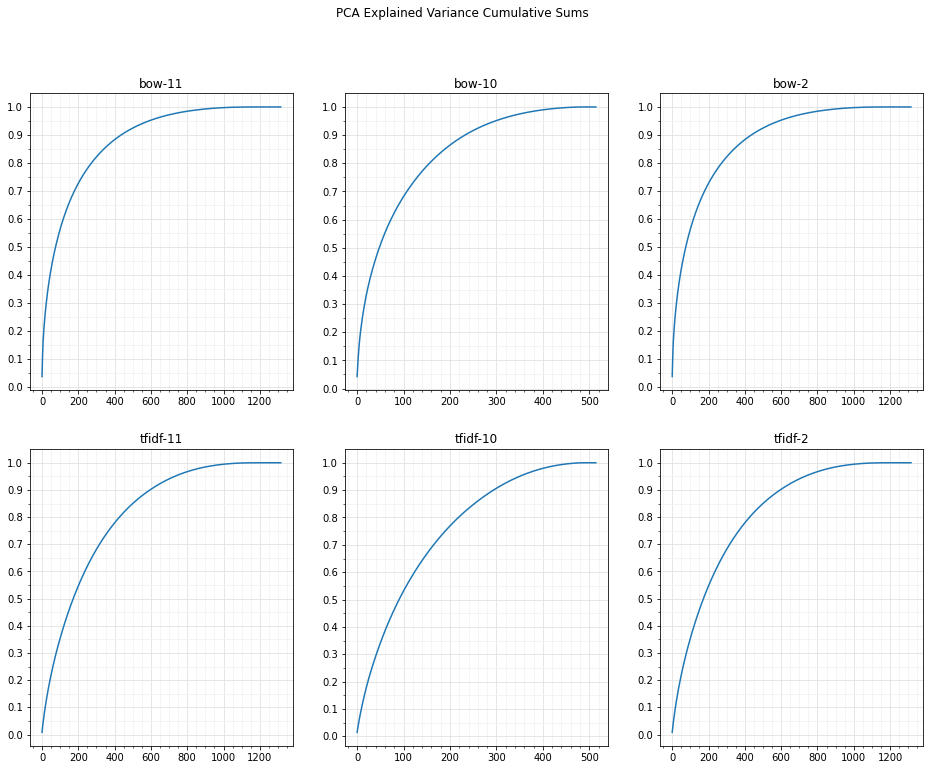

In [20]:
import math
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

datasets = ['bow-11', 'bow-10', 'bow-2', 'tfidf-11', 'tfidf-10', 'tfidf-2']

def investigate_dataset(name, axs):
    df = pd.read_csv('/content/feature/1-{}.csv'.format(name), sep=',', header=0)
    X = df.drop('class', axis=1)

    components_count=min(X.shape[0], X.shape[1])
    pca = PCA(n_components=components_count)
    pca.fit(X)

    explained_variance_cumsum = pd.Series(data=pca.explained_variance_ratio_).sort_values(ascending=False).cumsum()

    axs.set_title(name)
    axs.plot(explained_variance_cumsum)
    axs.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    axs.set_yticks(np.linspace(0, 1, 11), minor=False)
    axs.set_yticks(np.linspace(0, 1, 21), minor=True)
    axs.grid(color='#e0e0e0', which='major')
    axs.grid(color='#f2f2f2', which='minor')

fig, axs = plt.subplots(2, 3)
fig.suptitle('PCA Explained Variance Cumulative Sums')
fig.set_size_inches(16, 12)

for index, dataset in enumerate(datasets):
    investigate_dataset(dataset, axs[math.floor(index / 3), index % 3])

fig.savefig('/content/Output/3-pca-investigation.png')

**PCA - Transform**

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

datasets = ['bow-11', 'bow-10', 'bow-2', 'tfidf-11', 'tfidf-10', 'tfidf-2']
component_counts = [300, 200, 250, 400, 300, 500] # based on slope of explained variance cumulative sum curves from 3-pca-investigate.py (98% - 99%)

print('** Explained Variance **')

def transform_dataset(name, component_count):
    df = pd.read_csv('/content/feature/1-{}.csv'.format(name), sep=',', header=0)
    X = df.drop('class', axis=1)

    pca = PCA(n_components=component_count)
    pca.fit(X)
    print('{:<9}: {:.3f}%'.format(name, sum(pca.explained_variance_ratio_[:component_count]) * 100))

    X_new = pca.transform(X)
    X_new_cols = [ 'Comp{}'.format(index + 1) for index in range(X_new.shape[1]) ]
    df_output = pd.DataFrame(data=X_new, columns=X_new_cols)
    df_output['class'] = df['class']

    df_output.to_csv('/content/Output/3-{}.csv'.format(name), sep=',', header=True, index=False)

for index, dataset in enumerate(datasets):
    transform_dataset(dataset, component_counts[index])

** Explained Variance **
bow-11   : 81.868%
bow-10   : 86.137%
bow-2    : 77.647%
tfidf-11 : 77.387%
tfidf-10 : 90.358%
tfidf-2  : 84.643%


**Model selection and evaluation**

In [9]:
dataset1 = pd.read_csv("/content/feature/1-bow-10.csv")
dataset1.head()

categ = ['class']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dataset1[categ] = dataset1[categ].apply(le.fit_transform)

In [10]:
X = dataset1.drop('class', axis=1)
y = dataset1['class']

**Importing Libraraies--Model selection**

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from re import VERBOSE
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=ConvergenceWarning)
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score

**Model Evaluation**

In [ ]:
from sklearn.linear_model import LogisticRegression
# configure the cross-validation procedure
from imblearn.over_sampling import SMOTE
smt = SMOTE(k_neighbors=5,sampling_strategy='minority')
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results1 = list()
outer_results2 = list()
outer_results3 = list()
outer_results4 = list()
for train_ix, test_ix in cv_outer.split(X):
  X_train, y_train = smt.fit_resample(X.iloc[train_ix, :], y[train_ix])
  X_test, y_test = X.iloc[test_ix, :], y[test_ix]
  # configure the cross-validation procedure
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
  # define the models
  dt = tree.DecisionTreeClassifier()
  rf = RandomForestClassifier(verbose=0)
  lr = LogisticRegression()
  sv = svm.SVC(verbose=0)  
  knn = KNeighborsClassifier()
  
  #------------------------------------------------------------------------------------
  # define search space
  dt_space = dict()
  dt_space['max_depth'] = [2,4,6]
  rf_space = dict()
  rf_space['n_estimators'] = [10, 50, 100]
  rf_space['max_features'] = ['sqrt','log','None']
  lr_space = dict()
  lr_space['penalty'] = ['none','l2','l1','elasticnet']
  svm_space = dict()
  svm_space['kernel']=['linear','poly','rbf']
  svm_space['C']=[0.1, 1, 10, 100, 1000]
  knn_space = dict()
  knn_space['n_neighbors'] = [3,5,11]
  

  #------------------------------------------------------------------------------------
  
  # define search
  search1 = GridSearchCV(dt, dt_space, scoring='accuracy', cv=cv_inner, refit=True) # Search for DT
  search2 = GridSearchCV(rf, rf_space, scoring='accuracy', cv=cv_inner, refit=True) # Search for RFC
  search3 = GridSearchCV(lr, lr_space, scoring='accuracy', cv=cv_inner, refit=True) # Search for LR
  search4 = GridSearchCV(sv, svm_space, scoring='accuracy', cv=cv_inner, refit=True) # Search for SVM
  search5 = GridSearchCV(knn, knn_space, scoring='accuracy', cv=cv_inner, refit=True) # Search for SVM

  #-------------------------------------------------------------------------------------
  
  # execute search
  result1 = search1.fit(X_train, y_train)
  result2 = search2.fit(X_train, y_train)
  result3 = search3.fit(X_train, y_train)
  result4 = search4.fit(X_train, y_train)
  result5 = search4.fit(X_train, y_train)

  #---------------------------------------------------------------------------------------

	# get the best performing model fit on the whole training set
  best_model1 = result1.best_estimator_
  best_model2 = result2.best_estimator_
  best_model3 = result3.best_estimator_
  best_model4 = result4.best_estimator_
  best_model5 = result4.best_estimator_
  #-----------------------------------------------------------------------------------------

	# evaluate model on the hold out dataset
  yhat1 = best_model1.predict(X_test)
  yhat2 = best_model2.predict(X_test)
  yhat3 = best_model3.predict(X_test)
  yhat4 = best_model4.predict(X_test)
  yhat5 = best_model4.predict(X_test)
  #-----------------------------------------------------------------------------------------

	# evaluate the model
  acc1 = accuracy_score(y_test, yhat1)
  acc2 = accuracy_score(y_test, yhat2)
  acc3 = accuracy_score(y_test, yhat3)
  acc4 = accuracy_score(y_test, yhat4)
  acc5 = accuracy_score(y_test, yhat4)
  #------------------------------------------------------------------------------------------

  # evaluate the precision:
  prec1 = precision_score(y_test, yhat1,average='macro')
  prec2 = precision_score(y_test, yhat2,average='macro')
  prec3 = precision_score(y_test, yhat3,average='macro')
  prec4 = precision_score(y_test, yhat4,average='macro')
  prec5 = precision_score(y_test, yhat5,average='macro')


  #evaluate the recall score:
  r1 = recall_score(y_test, yhat1,average='macro')
  r2 = recall_score(y_test, yhat2,average='macro')
  r3 = recall_score(y_test, yhat3,average='macro')
  r4 = recall_score(y_test, yhat4,average='macro')
  r5 = recall_score(y_test, yhat5,average='macro')

  #evaluate the f1 score:
  f1 = f1_score(y_test, yhat1,average='macro')
  f2 = f1_score(y_test, yhat2,average='macro')
  f3 = f1_score(y_test, yhat3,average='macro')
  f4 = f1_score(y_test, yhat4,average='macro')
  f5 = f1_score(y_test, yhat5,average='macro')

	# store the result
  outer_results1.append(acc1)
  outer_results1.append(acc2)
  outer_results1.append(acc3)
  outer_results1.append(acc4)
  outer_results1.append(acc5)

  outer_results2.append(prec1)
  outer_results2.append(prec2)
  outer_results2.append(prec3)
  outer_results2.append(prec4)
  outer_results2.append(prec5)

  outer_results3.append(r1)
  outer_results3.append(r2)
  outer_results3.append(r3)
  outer_results3.append(r4)
  outer_results3.append(r5)

  outer_results4.append(f1)
  outer_results4.append(f2)
  outer_results4.append(f3)
  outer_results4.append(f4)
  outer_results4.append(f5)

  #-------------------------------------------------------------------------------------------


	# report progress
  print('Decision Tree Score Accuracy: >acc=%.3f, est=%.3f, cfg=%s' % (acc1, result1.best_score_, result1.best_params_))
  print('Random Forest Score Accuarcy: >acc=%.3f, est=%.3f, cfg=%s' % (acc2, result2.best_score_, result2.best_params_))
  print('Logistic Regression Accuracy: >acc=%.3f, est=%.3f, cfg=%s' % (acc3, result3.best_score_, result3.best_params_))
  print('Support Vector Machine Score Accuracy: >acc=%.3f, est=%.3f, cfg=%s' % (acc4, result4.best_score_, result4.best_params_))
  print('KNN classifier Accuracy: >acc=%.3f, est=%.3f, cfg=%s' % (acc5, result4.best_score_, result4.best_params_))

  print('Decision Tree Score Prec: >prec=%.3f, est=%.3f, cfg=%s' % (prec1, result1.best_score_, result1.best_params_))
  print('Random Forest Score Prec: >prec=%.3f, est=%.3f, cfg=%s' % (prec2, result2.best_score_, result2.best_params_))
  print('Logistic Regression Prec: >prec=%.3f, est=%.3f, cfg=%s' % (prec3, result3.best_score_, result3.best_params_))
  print('Support Vector Machine Prec: >prec=%.3f, est=%.3f, cfg=%s' % (prec4, result4.best_score_, result4.best_params_))
  print('KNN classifier Prec:  >prec=%.3f, est=%.3f, cfg=%s' % (prec5, result4.best_score_, result4.best_params_))

  print('Decision Tree Score Recall: >rec=%.3f, est=%.3f, cfg=%s' % (r1, result1.best_score_, result1.best_params_))
  print('Random Forest Scores Recall: >rec=%.3f, est=%.3f, cfg=%s' % (r2, result2.best_score_, result2.best_params_))
  print('Logistic Regression Recall: >rec=%.3f, est=%.3f, cfg=%s' % (r3, result3.best_score_, result3.best_params_))
  print('Support Vector Machine Recall: >rec=%.3f, est=%.3f, cfg=%s' % (r4, result4.best_score_, result4.best_params_))
  print('KNN classifier Recall: >rec=%.3f, est=%.3f, cfg=%s' % (r5, result4.best_score_, result4.best_params_))

  print('Decision Tree Scores F: >F=%.3f, est=%.3f, cfg=%s' % (f1, result1.best_score_, result1.best_params_))
  print('Random Forest Scores F: >F=%.3f, est=%.3f, cfg=%s' % (f2, result2.best_score_, result2.best_params_))
  print('Logistic Regression F: >F=%.3f, est=%.3f, cfg=%s' % (f3, result3.best_score_, result3.best_params_))
  print('Support Vector Machine F: >F=%.3f, est=%.3f, cfg=%s' % (f4, result4.best_score_, result4.best_params_))
  print('KNN classifier F: >F=%.3f, est=%.3f, cfg=%s' % (f5, result4.best_score_, result4.best_params_))
 
print('Accuracy: %.3f (%.3f)' % (mean(outer_results1), std(outer_results1)))
print('Precision: %.3f (%.3f)' % (mean(outer_results2), std(outer_results2)))
print('Recall: %.3f (%.3f)' % (mean(outer_results3), std(outer_results3)))
print('F1 Score: %.3f (%.3f)' % (mean(outer_results4), std(outer_results4)))